In [1]:
import copy
import numpy as np
import pandas as pd

from src.common.functions import get_feature_importance
%cd /home/heza7322/PycharmProjects/missing-value-handling-in-carts
#%cd /Users/Henning/PycharmProjects/missing-value-handling-in-carts
import matplotlib.pyplot as plt
from src.binary_tree import BinaryTree
from src.trinary_tree import TrinaryTree
from src.weighted_tree import WeightedTree
from src.common.functions import get_indices, calculate_loss, fit_response


/home/heza7322/PycharmProjects/missing-value-handling-in-carts


In [8]:
df = pd.read_fwf('example_notebooks/data/german.data',header = None)
df = df.join(df[1].str.split(' ',expand=True),lsuffix='_').drop('1_',axis=1)
df.columns = np.arange(df.shape[1])
df['y'] = ['yes' if y=='1' else 'no' for y in df[df.columns[-1]]]
features = df.columns[:-1]

In [2]:
df = pd.read_fwf('example_notebooks/data/balance-scale.data',header = None)[0]
df = df.str.split(',',expand=True)
df.rename({0:'y'},axis=1,inplace=True)
features = df.drop('y',axis=1).columns

In [3]:
# Test train split
n = len(df)
df['test'] = False
index_train = np.random.choice(df.index,int(n*0.2))
df.loc[index_train,'test'] = True

# Set up trees
max_depth = 3
min_samples_leaf = 5
tree_types = {'majority': BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf,missing_rule='majority'),
              'mia':      BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf,missing_rule='mia'),
              'trinary':  TrinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf),
              'weighted': WeightedTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf)}

In [5]:
# Missingness of different frequencies
missing_probs = [0,0.25,0.5,0.75]

dfs = {0: df.copy()}
n_to_remove = [0]
for i in range(1,len(missing_probs)):
    n_to_remove += [int(missing_probs[i]*n) - sum(n_to_remove[:i])]
    dfs[i] = dfs[i-1].copy()
    for feature in features:
        to_remove = dfs[i].loc[~dfs[i][feature].isna()].sample(n_to_remove[i]).index
        dfs[i].loc[to_remove,feature] = np.nan

In [ ]:
# Fit trees
results = pd.DataFrame(columns = [key for key in tree_types], index = missing_probs)
for i,missing_prob in enumerate(missing_probs):
    print(missing_prob)
    X_train = dfs[i].loc[~dfs[i]['test'],features]
    y_train = dfs[i].loc[~dfs[i]['test'],'y']
    X_test  = dfs[i].loc[dfs[i]['test'],features]
    y_test  = dfs[i].loc[dfs[i]['test'],'y']
    for tree_name in tree_types:
        tree = copy.deepcopy(tree_types[tree_name])
        tree.fit(X_train,y_train)

        y_hat = tree.predict(X_test)
        mse = (y_test!=y_hat).mean()
        results.loc[missing_prob,tree_name] = mse
        print(tree_name)

(results-results.loc[0]).plot()

0
majority
mia
trinary
weighted
0.25
majority
mia
trinary
weighted
0.5
majority
mia
trinary
weighted
0.75
majority
mia
trinary
weighted


<Axes: >

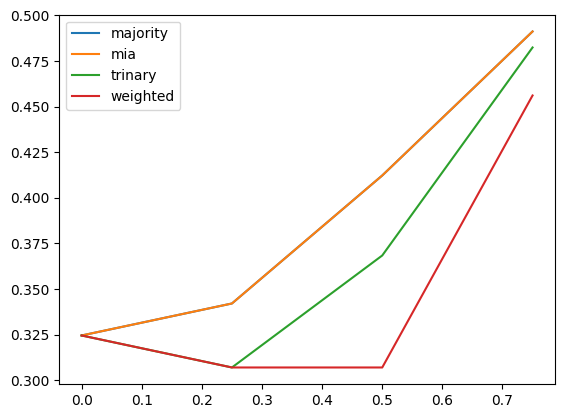

In [7]:
# Missingness of different frequencies ONLY in test data
dfs_2 = {i: dfs[i].copy() for i in range(len(missing_probs))}
for i in range(1,len(missing_probs)):
    dfs_2[i].loc[~dfs_2[i]['test']] = df.loc[~df['test']].copy()

X_train = df.loc[~df['test'],features]
y_train = df.loc[~df['test'],'y']
fitted_trees = {}
for tree_name in tree_types:
    fitted_trees[tree_name] = copy.deepcopy(tree_types[tree_name])
    fitted_trees[tree_name].fit(X_train,y_train)

# Fit trees
results = pd.DataFrame(columns = [key for key in tree_types], index = missing_probs)
for i,missing_prob in enumerate(missing_probs):
    print(missing_prob)
    X_test  = dfs_2[i].loc[dfs_2[i]['test'],features]
    y_test  = dfs_2[i].loc[dfs_2[i]['test'],'y']
    for tree_name in tree_types:
        y_hat = fitted_trees[tree_name].predict(X_test)
        mse = (y_test!=y_hat).mean()
        results.loc[missing_prob,tree_name] = mse
        print(tree_name)

results.plot()